In [5]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Cell 2: Define Data Loading Functions
def get_available_medicines(city):
    """Get list of available medicine datasets for a city"""
    processed_dir = Path(f"../../dataset/data/{city}/processed")
    files = list(processed_dir.glob("*_prophet.csv"))
    return [f.stem.replace('_prophet', '') for f in files]

def load_data(city, medicine):
    """Load Prophet-ready dataset for a specific city and medicine"""
    file_path = Path(f"../../dataset/data/{city}/processed/{medicine}_prophet.csv")
    df = pd.read_csv(file_path)
    df['ds'] = pd.to_datetime(df['ds'])
    return df

# List available medicines for each city
print("Delhi Medicines:", get_available_medicines('delhi'))
print("Kolkata Medicines:", get_available_medicines('kolkata'))

Delhi Medicines: ['amoxicillin', 'cetirizine', 'ibuprofen', 'paracetamol', 'salbutamol']
Kolkata Medicines: ['amoxicillin', 'ibuprofen', 'loperamide', 'metronidazole', 'paracetamol']


In [16]:
# Cell 3: Load and Display Sample Data
# Load data for one medicine from each city
delhi_paracetamol = load_data('delhi', 'paracetamol')
kolkata_paracetamol = load_data('kolkata', 'paracetamol')

print("\nDelhi Paracetamol Data:")
print(delhi_paracetamol.head())
print("\nShape:", delhi_paracetamol.shape)

print("\nKolkata Paracetamol Data:")
print(kolkata_paracetamol.head())
print("\nShape:", kolkata_paracetamol.shape)


Delhi Paracetamol Data:
   medicine_id         ds    y
0            1 2020-01-01  122
1            1 2020-01-02   93
2            1 2020-01-03  104
3            1 2020-01-04   62
4            1 2020-01-05   98

Shape: (1461, 3)

Kolkata Paracetamol Data:
   medicine_id         ds    y
0            1 2020-01-01  100
1            1 2020-01-02   77
2            1 2020-01-03   83
3            1 2020-01-04   84
4            1 2020-01-05   80

Shape: (1461, 3)



=== Delhi Paracetamol Analysis ===

Basic Statistics:
count    1461.000000
mean      160.855578
std       106.147121
min        47.000000
25%        98.000000
50%       120.000000
75%       162.000000
max       645.000000
Name: y, dtype: float64


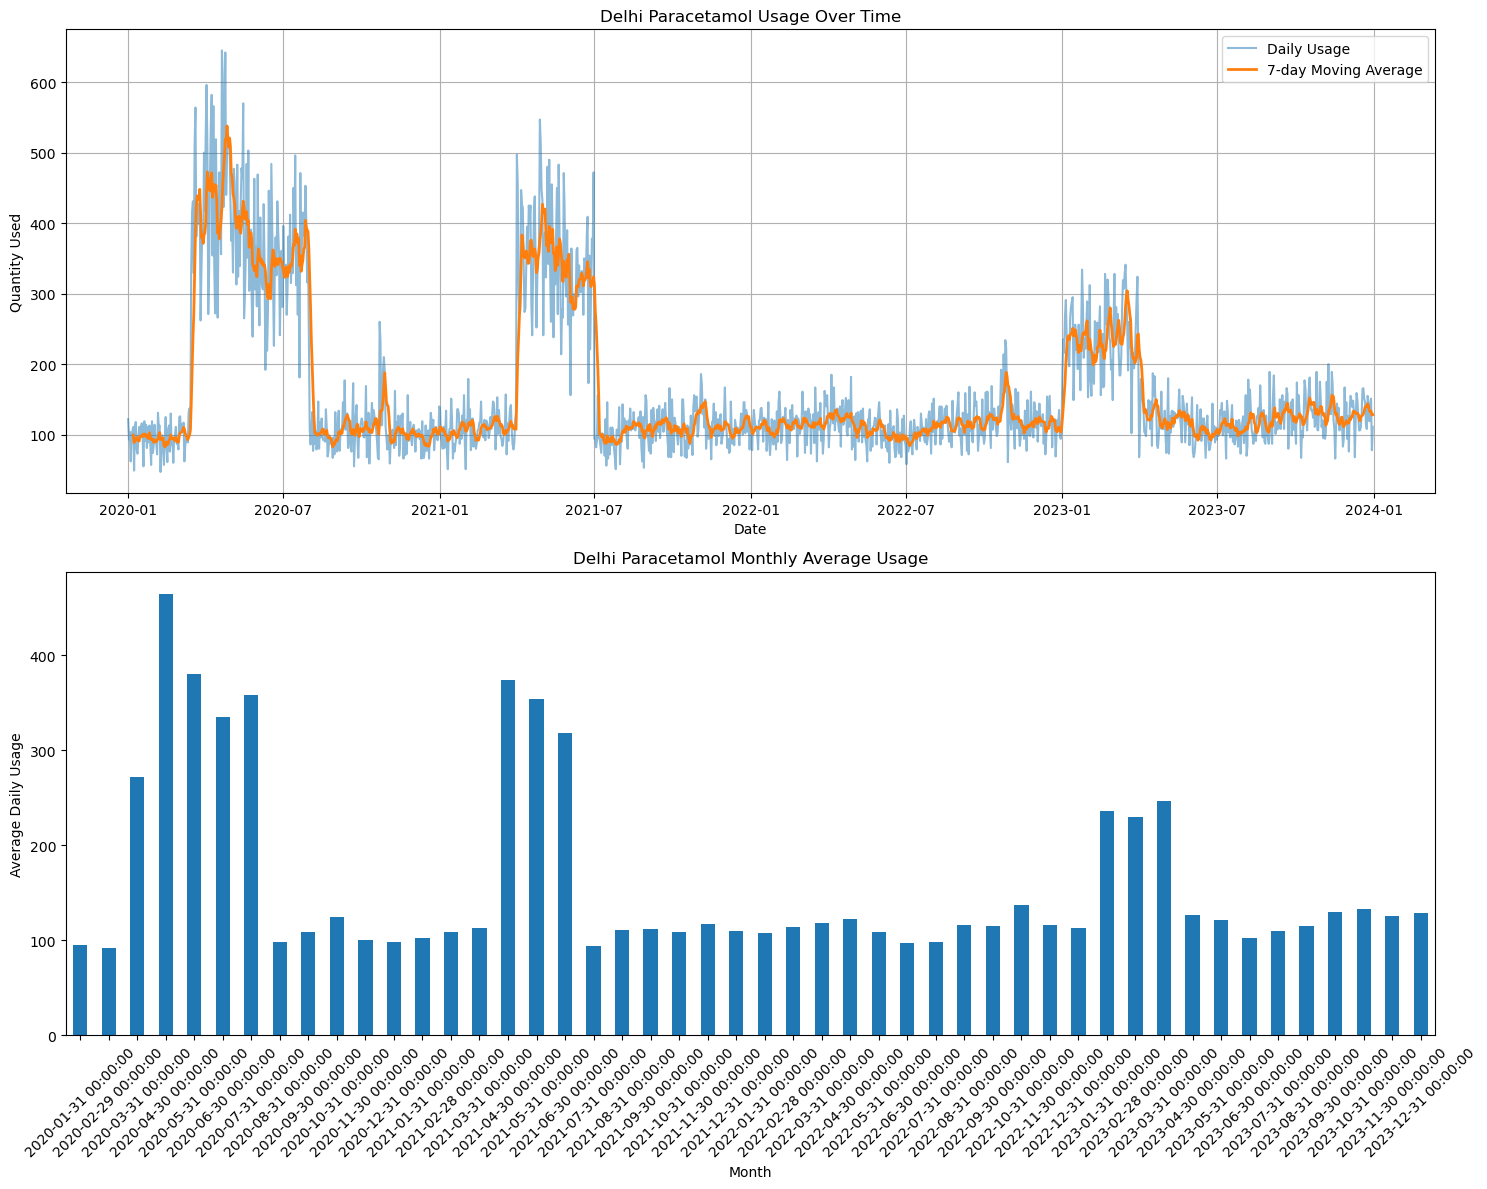


=== Kolkata Paracetamol Analysis ===

Basic Statistics:
count    1461.000000
mean      159.577687
std       109.500811
min        19.000000
25%        92.000000
50%       116.000000
75%       164.000000
max       693.000000
Name: y, dtype: float64


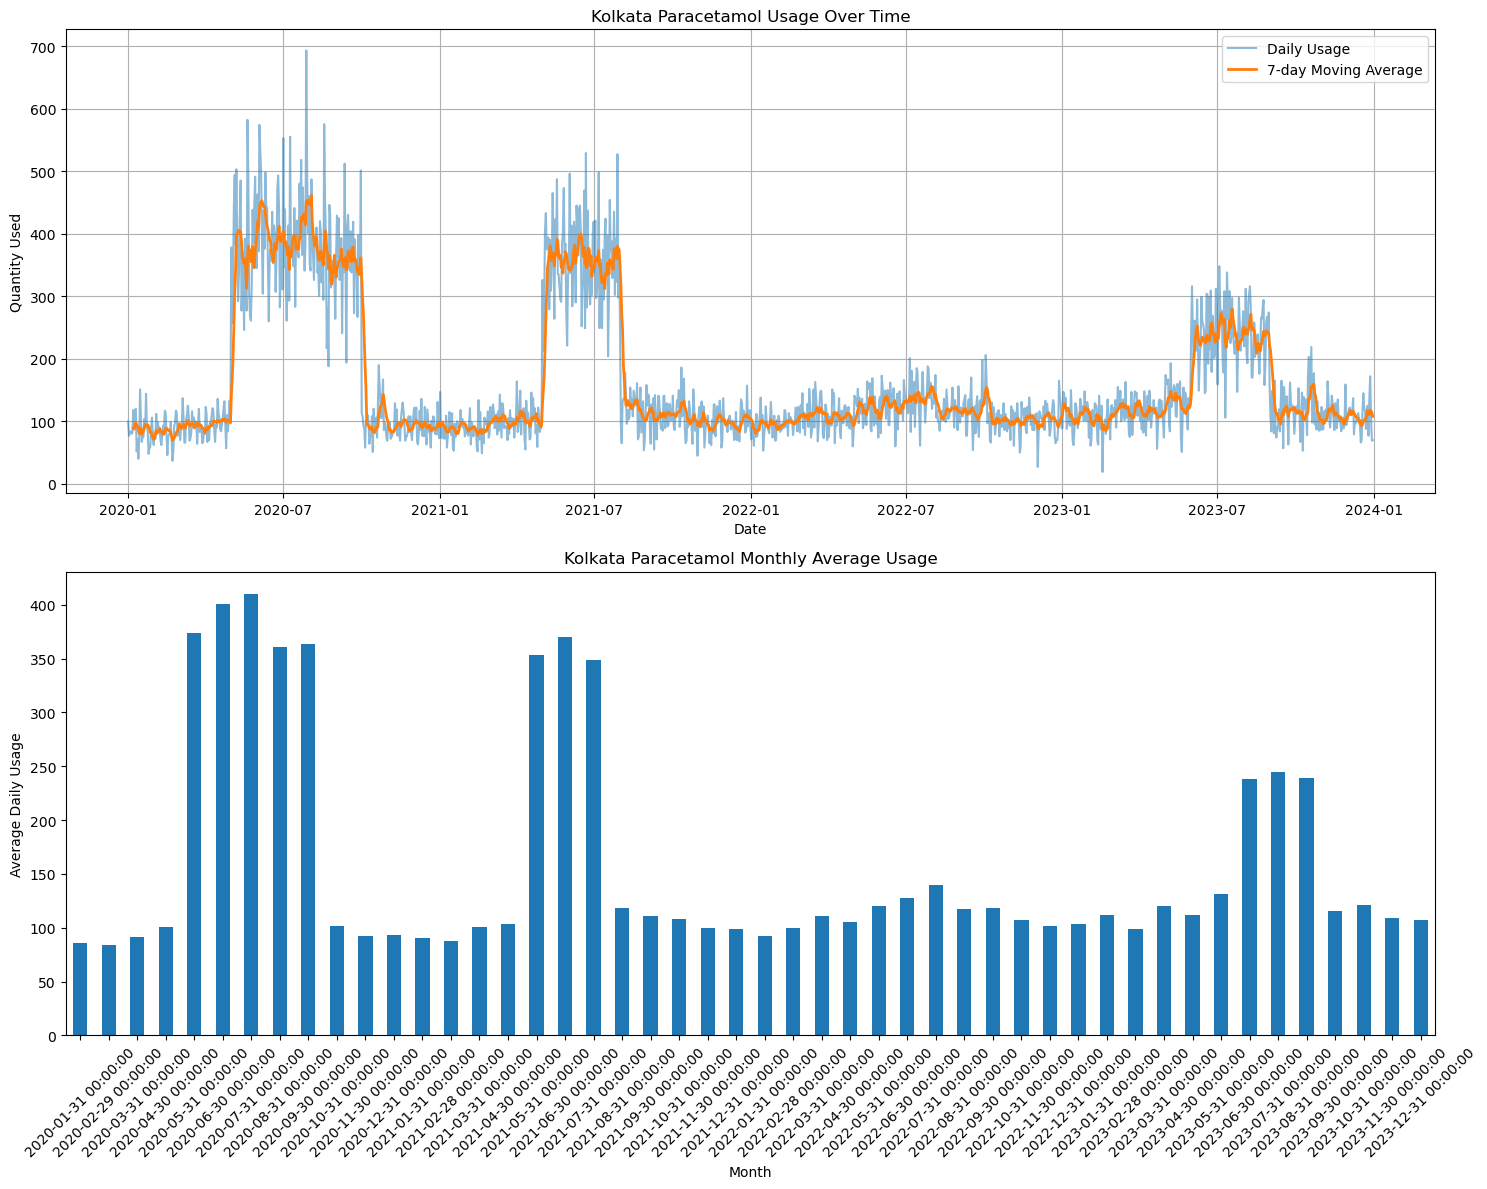

In [17]:
# Cell 4: Basic Data Analysis
def analyze_medicine_data(df, title):
    """Perform basic statistical analysis on medicine usage data"""
    print(f"\n=== {title} Analysis ===")
    print("\nBasic Statistics:")
    print(df['y'].describe())
    
    # Monthly average usage
    monthly_usage = df.set_index('ds').resample('M')['y'].mean()
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Time series plot
    ax1.plot(df['ds'], df['y'], label='Daily Usage', alpha=0.5)
    ax1.plot(df['ds'], df['y'].rolling(window=7).mean(), 
            label='7-day Moving Average', linewidth=2)
    ax1.set_title(f'{title} Usage Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity Used')
    ax1.legend()
    ax1.grid(True)
    
    # Monthly average bar plot
    monthly_usage.plot(kind='bar', ax=ax2)
    ax2.set_title(f'{title} Monthly Average Usage')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Average Daily Usage')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Analyze both cities
analyze_medicine_data(delhi_paracetamol, "Delhi Paracetamol")
analyze_medicine_data(kolkata_paracetamol, "Kolkata Paracetamol")

02:27:46 - cmdstanpy - INFO - Chain [1] start processing
02:27:47 - cmdstanpy - INFO - Chain [1] done processing



=== Delhi Paracetamol Model Evaluation ===
MAPE: 25.42%
RMSE: 34.40


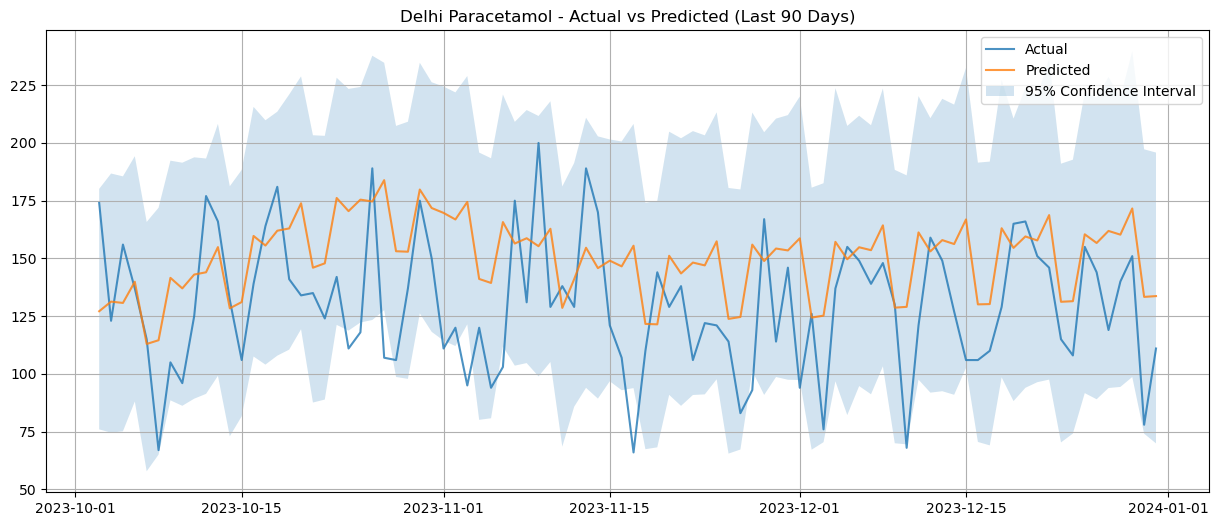

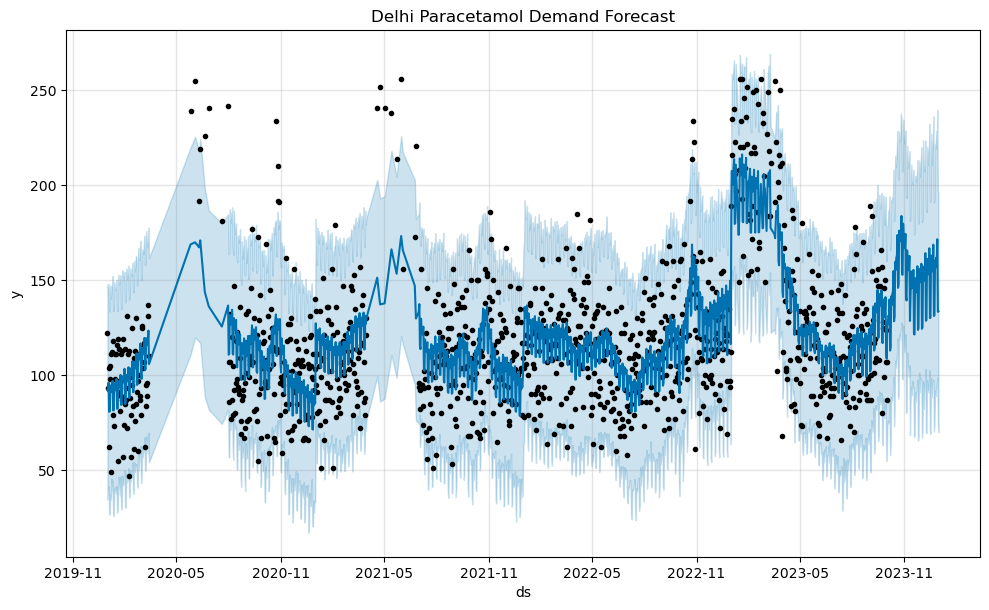

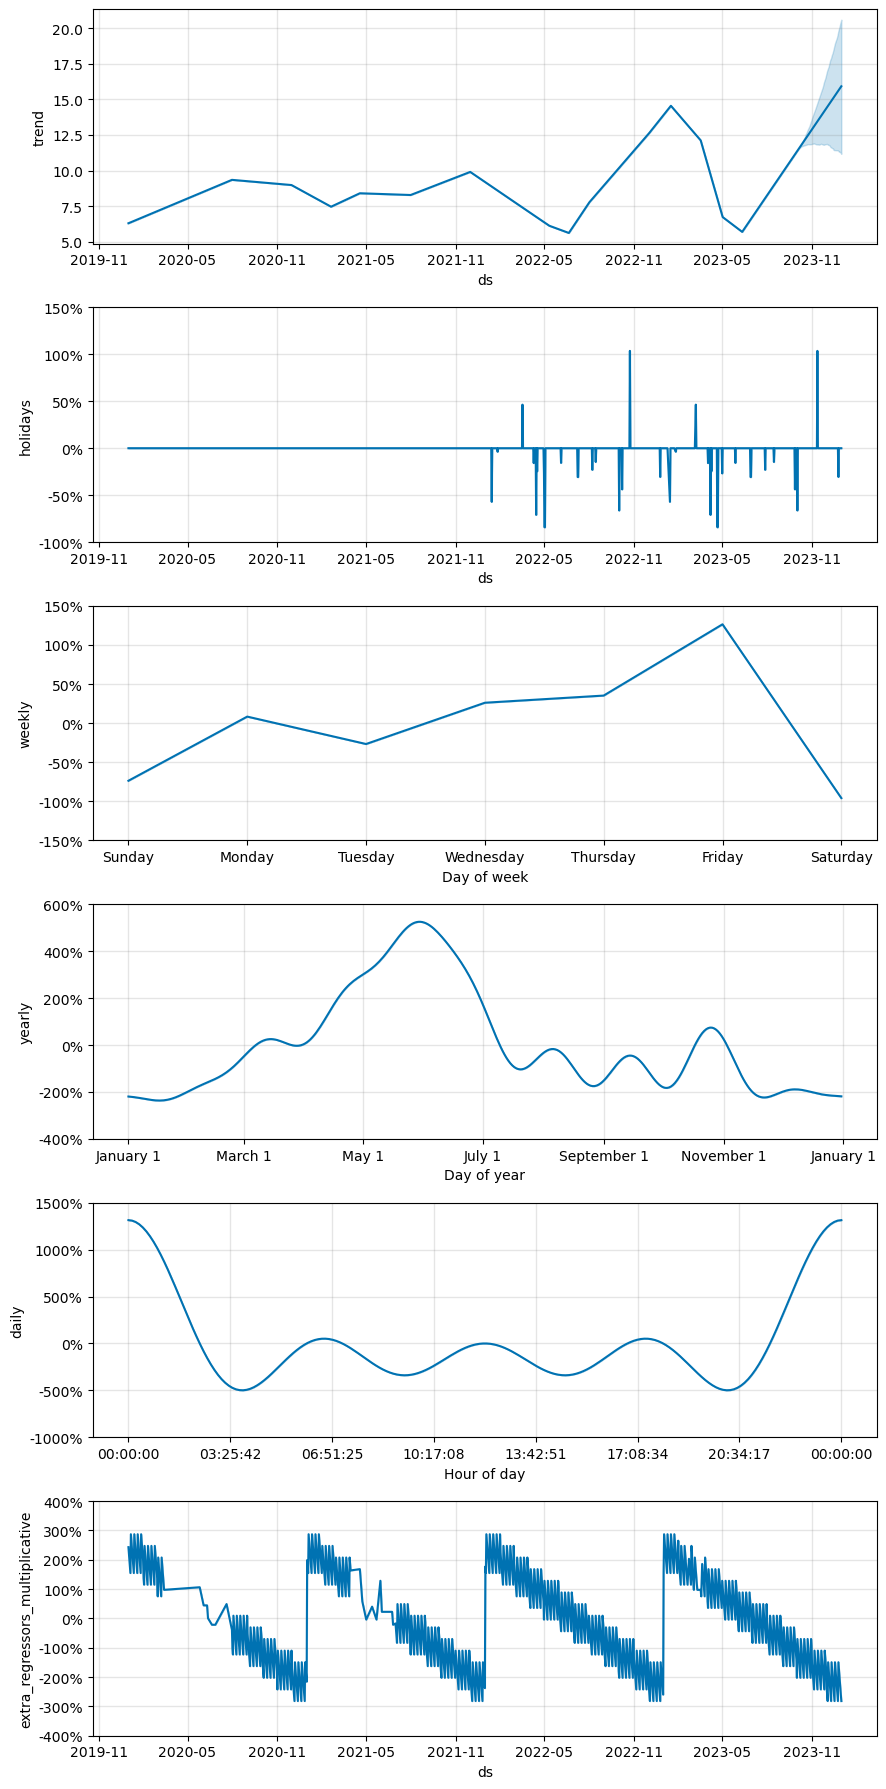

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Cross-validation metrics:
   horizon           mse        rmse         mae      mape     mdape  \
0  10 days   2626.896629   51.253260   36.300078  0.323968  0.217875   
1  11 days   2481.976841   49.819442   36.961398  0.333752  0.227276   
2  12 days   4437.832445   66.617058   39.520222  0.342749  0.218415   
3  13 days   7219.779906   84.969288   42.579892  0.369127  0.218415   
4  14 days  10006.000565  100.029998   46.665057  0.409781  0.217875   
..     ...           ...         ...         ...       ...       ...   
76 86 days  59447.655772  243.818900  121.009300  1.144012  0.411121   
77 87 days  62823.433727  250.646033  122.058935  1.156298  0.449584   
78 88 days  65787.847202  256.491417  122.039068  1.157674  0.430110   
79 89 days  67786.307119  260.358036  122.755662  1.144934  0.436258   
80 90 days  68816.656919  262.329291  122.682222  1.142812  0.421899   

       smape  coverage  
0   0.300434  0.764616  
1   0.308005  0.749107  
2   0.310717  0.745230  
3   0.31

02:27:57 - cmdstanpy - INFO - Chain [1] start processing
02:27:58 - cmdstanpy - INFO - Chain [1] done processing



=== Kolkata Paracetamol Model Evaluation ===
MAPE: 32.78%
RMSE: 36.83


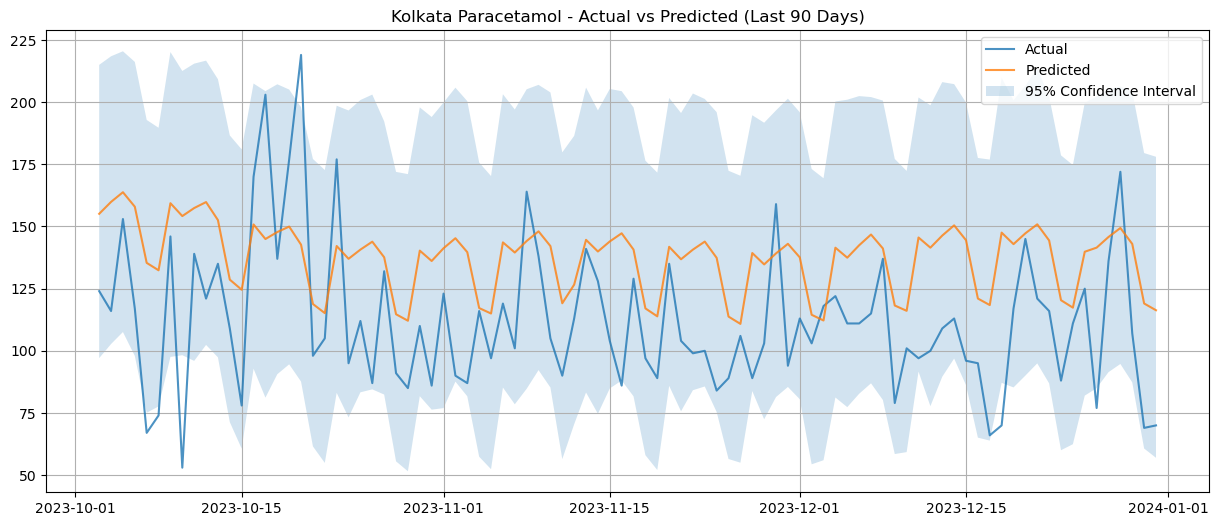

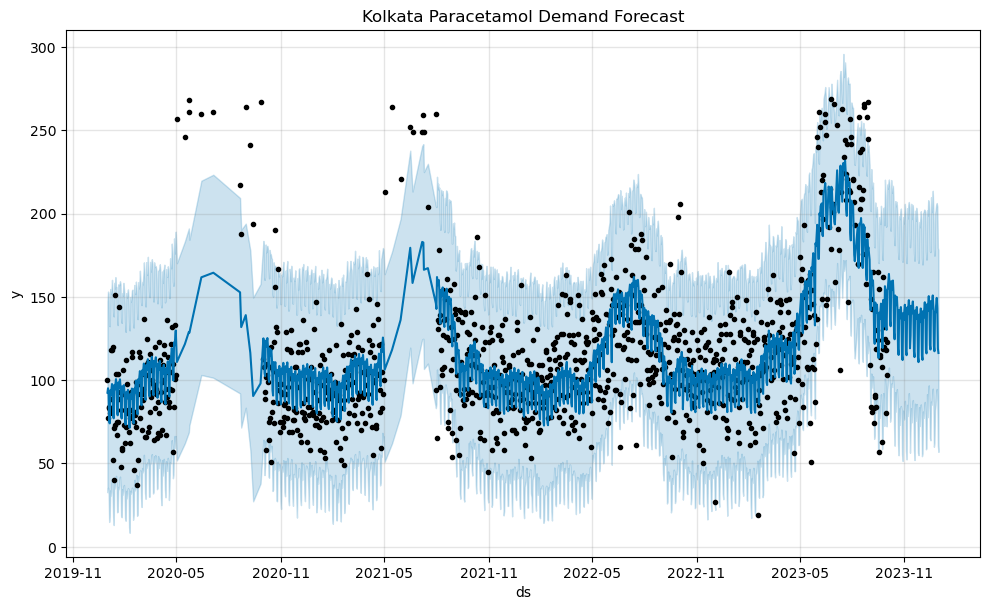

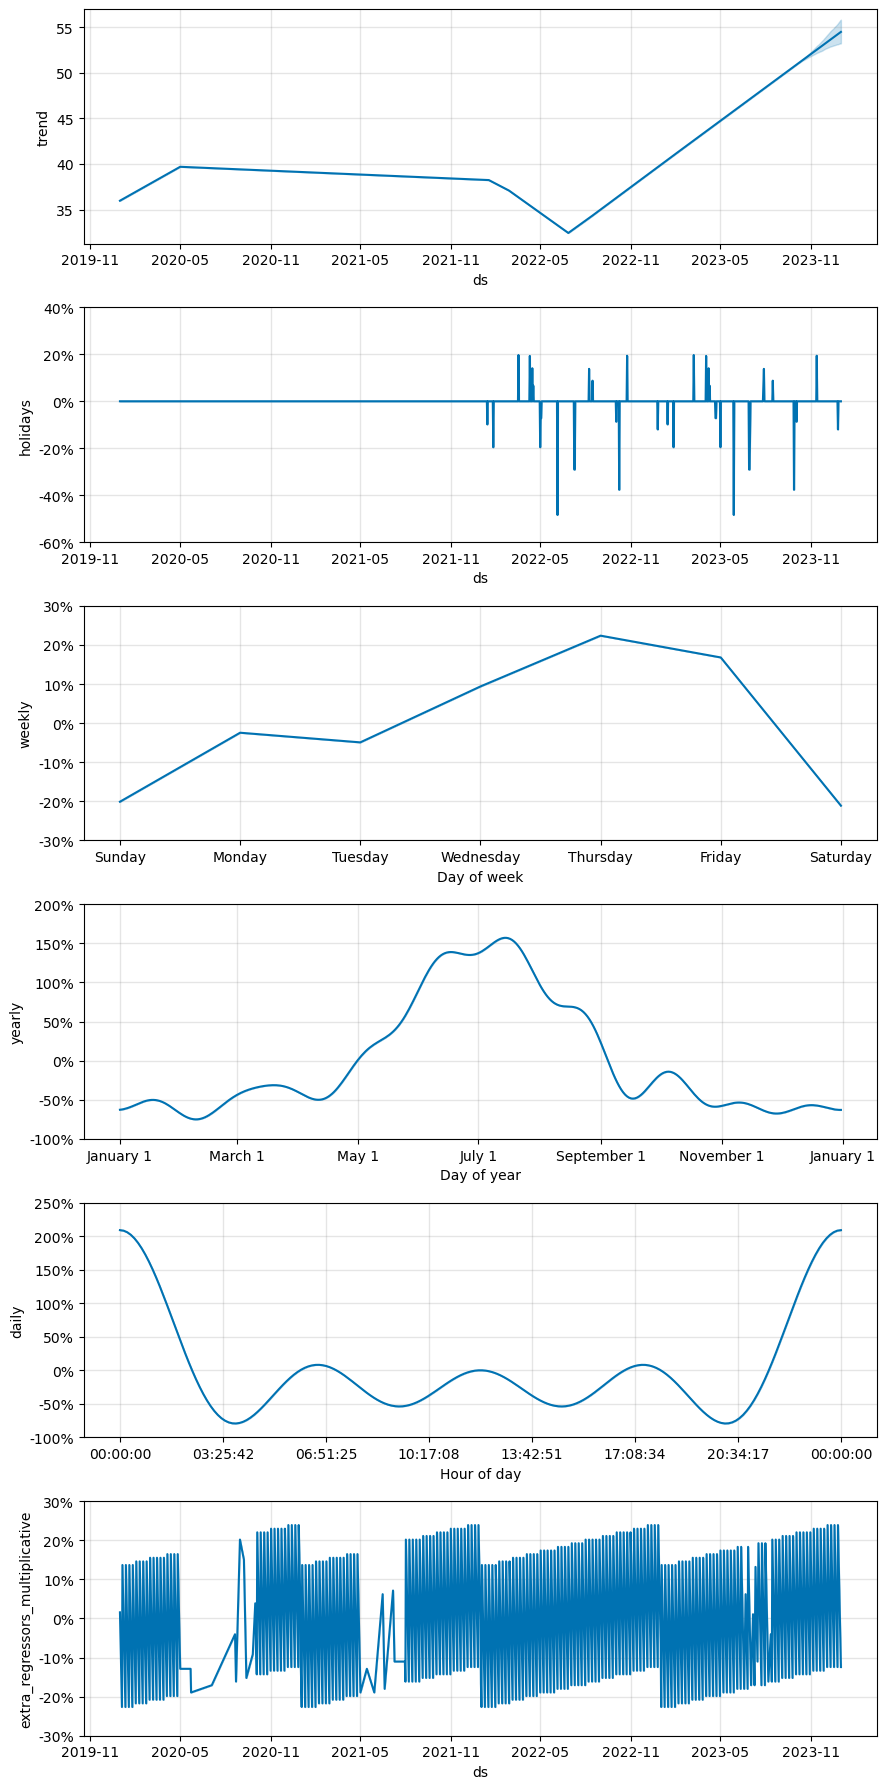

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Cross-validation metrics:
   horizon           mse        rmse         mae      mape     mdape  \
0  10 days   1853.326580   43.050280   29.890665  0.266999  0.188153   
1  11 days   1985.481763   44.558745   30.370398  0.270226  0.179986   
2  12 days   2206.045466   46.968558   32.001352  0.289574  0.193452   
3  13 days   2528.913697   50.288306   34.488890  0.327268  0.201725   
4  14 days   2836.383764   53.257711   36.435176  0.346273  0.209014   
..     ...           ...         ...         ...       ...       ...   
76 86 days  30241.240148  173.900087  103.635000  1.004636  0.373798   
77 87 days  30412.702734  174.392382  103.931821  1.013361  0.368633   
78 88 days  30319.642039  174.125363  102.952896  0.996362  0.373798   
79 89 days  30363.907094  174.252423  103.533001  1.009470  0.389835   
80 90 days  30672.385506  175.135335  104.343907  1.026116  0.389835   

       smape  coverage  
0   0.237613  0.810842  
1   0.238241  0.802552  
2   0.250330  0.790225  
3   0.26

In [24]:
# Cell 5: Enhanced Prophet Model Training Function
def train_and_evaluate_prophet(df, city, medicine, periods=90):
    """Train Prophet model with enhanced parameters and features"""
    # Add additional features
    df['month'] = df['ds'].dt.month
    df['day_of_week'] = df['ds'].dt.dayofweek
    
    # Handle outliers using IQR method
    Q1 = df['y'].quantile(0.25)
    Q3 = df['y'].quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df[
        (df['y'] >= Q1 - 1.5 * IQR) & 
        (df['y'] <= Q3 + 1.5 * IQR)
    ].copy()
    
    # Split data into train and test (last 90 days for testing)
    train = df_clean[:-90].copy()
    test = df_clean[-90:].copy()
    
    # Before creating the Prophet model
    if city.lower() == 'delhi' or city.lower() == 'kolkata':
        import holidays
        
        # Create India holidays
        india_holidays = holidays.India(years=[2022, 2023, 2024])
        
        # Convert to DataFrame for Prophet
        holiday_df = pd.DataFrame([
            {'ds': pd.to_datetime(date), 'holiday': name}
            for date, name in india_holidays.items()
        ])
    else:
        holiday_df = None

    # Initialize Prophet with holidays parameter
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='multiplicative',
        interval_width=0.95,
        changepoint_prior_scale=0.05,  # Flexibility in trend changes
        seasonality_prior_scale=10.0,  # Flexibility in seasonality
        holidays_prior_scale=10.0,     # Flexibility in holiday effects
        changepoint_range=0.9,         # Allow changepoints up to 90% of the data
        holidays=holiday_df            # Add holidays here
    )
    
    # Add additional regressors
    model.add_regressor('month')
    model.add_regressor('day_of_week')
    
    # Fit the model
    model.fit(train)
    
    # Create future dates dataframe with additional features
    future = model.make_future_dataframe(periods=periods)
    future['month'] = future['ds'].dt.month
    future['day_of_week'] = future['ds'].dt.dayofweek
    
    # Make predictions
    forecast = model.predict(future)
    
    # Calculate metrics on test set
    test_forecast = forecast[-90:]
    mape = np.mean(np.abs((test['y'].values - test_forecast['yhat'].values) / test['y'].values)) * 100
    rmse = np.sqrt(np.mean((test['y'].values - test_forecast['yhat'].values)**2))
    
    print(f"\n=== {city.title()} {medicine.title()} Model Evaluation ===")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(test['ds'], test['y'], label='Actual', alpha=0.8)
    plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Predicted', alpha=0.8)
    plt.fill_between(
        test_forecast['ds'],
        test_forecast['yhat_lower'],
        test_forecast['yhat_upper'],
        alpha=0.2,
        label='95% Confidence Interval'
    )
    plt.title(f'{city.title()} {medicine.title()} - Actual vs Predicted (Last 90 Days)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the full forecast
    fig = model.plot(forecast)
    plt.title(f'{city.title()} {medicine.title()} Demand Forecast')
    plt.show()
    
    # Plot the components
    fig = model.plot_components(forecast)
    plt.show()
    
    return model, forecast

# Add a function to perform cross-validation
from prophet.diagnostics import cross_validation, performance_metrics

def perform_cv(model, initial, period, horizon):
    """Perform cross-validation on the model"""
    df_cv = cross_validation(
        model, 
        initial=initial,    # e.g., '180 days'
        period=period,      # e.g., '30 days'
        horizon=horizon,    # e.g., '90 days'
        parallel="processes"
    )
    df_p = performance_metrics(df_cv)
    print("\nCross-validation metrics:")
    print(df_p)
    return df_cv, df_p

# Train models with cross-validation
delhi_model, delhi_forecast = train_and_evaluate_prophet(delhi_paracetamol, 'delhi', 'paracetamol')
delhi_cv, delhi_metrics = perform_cv(delhi_model, '180 days', '30 days', '90 days')

kolkata_model, kolkata_forecast = train_and_evaluate_prophet(kolkata_paracetamol, 'kolkata', 'paracetamol')
kolkata_cv, kolkata_metrics = perform_cv(kolkata_model, '180 days', '30 days', '90 days')

In [29]:
# Cell 8: Alternative Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

def prepare_features(df):
    """Prepare features for traditional ML models"""
    X = pd.DataFrame({
        'month': df['ds'].dt.month,
        'day': df['ds'].dt.day,
        'day_of_week': df['ds'].dt.dayofweek,
        'quarter': df['ds'].dt.quarter,
        'year': df['ds'].dt.year,
        'is_month_start': df['ds'].dt.is_month_start.astype(int),
        'is_month_end': df['ds'].dt.is_month_end.astype(int)
    })
    return X

def train_alternative_models(train_df, test_df):
    """Train and evaluate alternative models"""
    X_train = prepare_features(train_df)
    y_train = train_df['y']
    X_test = prepare_features(test_df)
    y_test = test_df['y']
    
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    
    # XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    
    # Print metrics
    print("\nRandom Forest Metrics:")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_pred)*100:.2f}%")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}")
    
    print("\nXGBoost Metrics:")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_pred)*100:.2f}%")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.2f}")
    
    return rf_model, xgb_model

# Try alternative models
rf_model, xgb_model = train_alternative_models(
    delhi_paracetamol[:-90], 
    delhi_paracetamol[-90:]
)


Random Forest Metrics:
MAPE: 21.31%
RMSE: 33.12

XGBoost Metrics:
MAPE: 25.16%
RMSE: 37.45


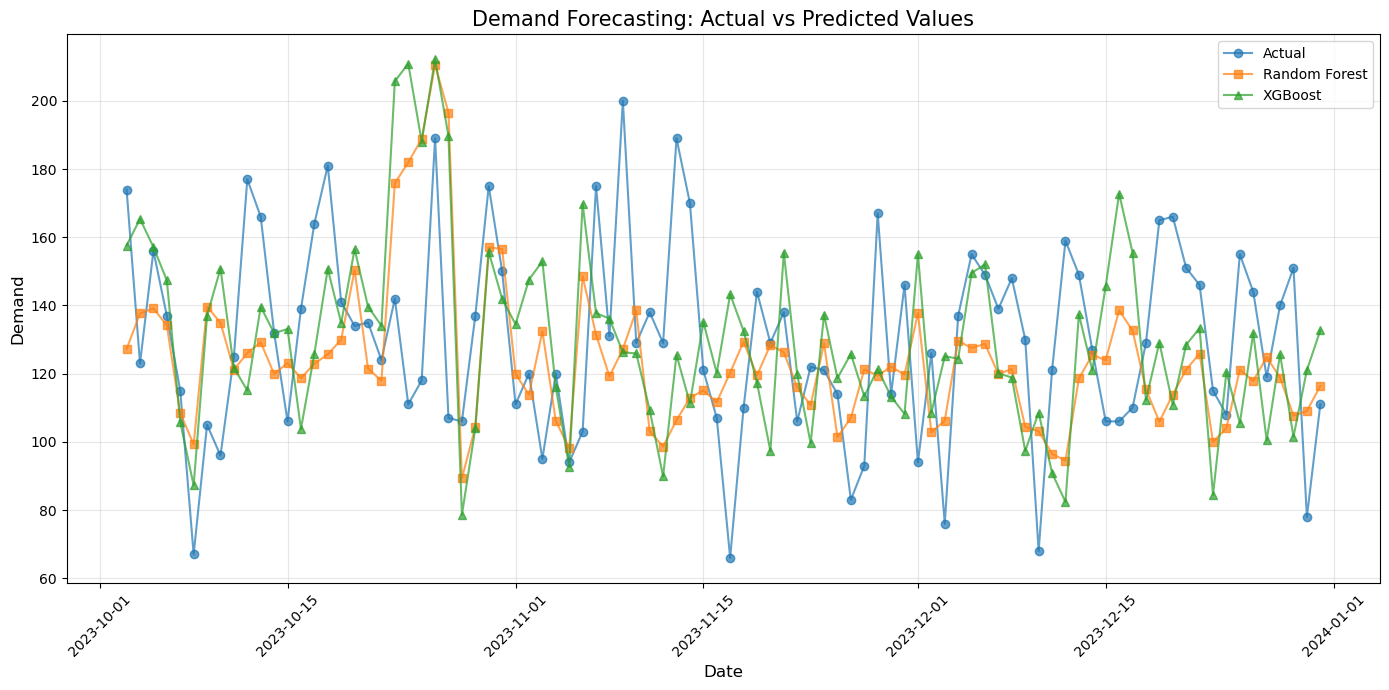

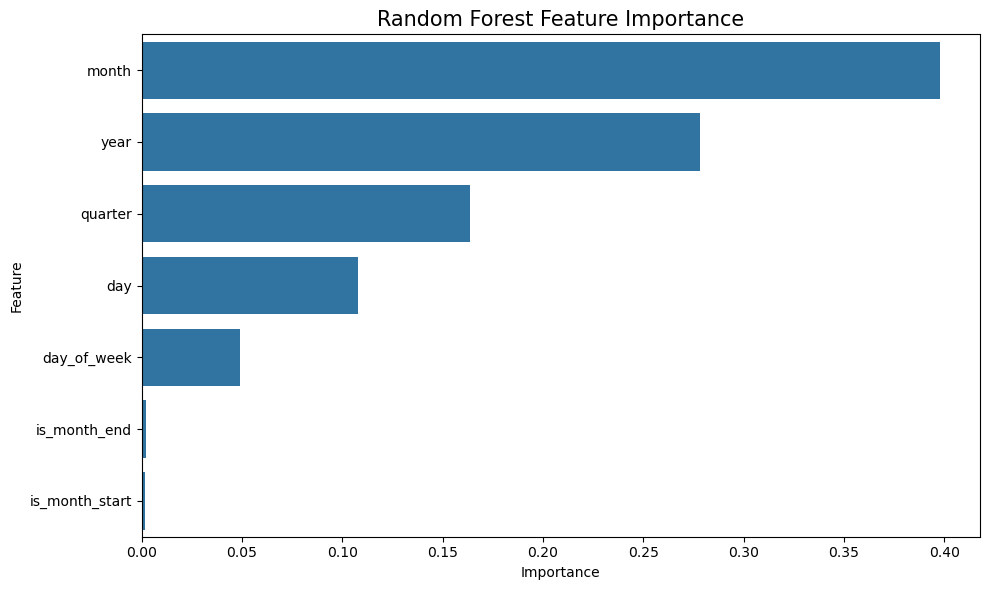

In [30]:
# Cell 9: Visualize Alternative Model Predictions
def plot_alternative_model_predictions(train_df, test_df, rf_model, xgb_model):
    """
    Plot predictions from Random Forest and XGBoost models against actual values
    """
    # Prepare test features
    X_test = prepare_features(test_df)
    
    # Make predictions
    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    # Create DataFrame with actual and predicted values
    results_df = pd.DataFrame({
        'Date': test_df['ds'],
        'Actual': test_df['y'],
        'Random Forest': rf_pred,
        'XGBoost': xgb_pred
    })
    
    # Plot
    plt.figure(figsize=(14, 7))
    
    plt.plot(results_df['Date'], results_df['Actual'], 'o-', label='Actual', alpha=0.7)
    plt.plot(results_df['Date'], results_df['Random Forest'], 's-', label='Random Forest', alpha=0.7)
    plt.plot(results_df['Date'], results_df['XGBoost'], '^-', label='XGBoost', alpha=0.7)
    
    plt.title('Demand Forecasting: Actual vs Predicted Values', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Demand', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()
    
    # Feature importance plot for Random Forest
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Random Forest Feature Importance', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    return results_df

# Visualize the predictions
prediction_results = plot_alternative_model_predictions(
    delhi_paracetamol[:-90], 
    delhi_paracetamol[-90:], 
    rf_model, 
    xgb_model
)